In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from gfosd import Problem 
import gfosd.components as comp

# Data generation

In [3]:
T = int(1e4)
np.random.seed(42)
aa = T//4
bb = T//6
pwl = np.r_[
    np.linspace(0, 3, num=aa, endpoint=False),
    np.linspace(3, 1.5, num=bb, endpoint=False),
    np.linspace(1.5, -3, num=bb, endpoint=False),
    np.linspace(-3, -2.5, num=aa, endpoint=False),
    np.linspace(-2.5, 0, num=T-2*(aa+bb), endpoint=False)
]
pwl = np.clip(pwl, -2.5, 2.5)   # note that the actual data is bounded in [-2.5, 2.5]
noise = 0.2 * np.random.randn(T)

y = pwl + noise
X_real = np.asarray([noise, pwl])
use_set = np.random.uniform(size=T) >= .2
y[~use_set] = np.nan

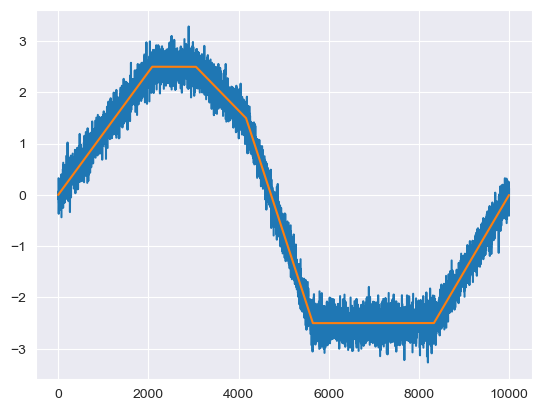

In [6]:
plt.figure()
plt.plot(y)
plt.plot(pwl)
plt.show();

# Basic $\ell_1$ Trend Problem Formulation

In [11]:
c1 = comp.SumSquare(weight=1/len(y))
c2 = comp.SumAbs(diff=2, weight=1)
# c2 = comp.Aggregate([
#     comp.SumAbs(diff=2, weight=1),
#     comp.Inequality(vmax=2.5, vmin=-2.5)
# ])

problem = Problem(y, [c1, c2])
problem.decompose(verbose=True)

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      1.52e-02s
(standard algorithm)

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 1.75e+00    1.31e+00     1.97e-01   [0.1 0.1]  1.54e-03
   25 | 9.05e-01    6.04e-02     5.97e-03   [0.1 0.1]  3.12e-02
   50 | 1.58e-01    1.76e-02     2.23e+00   [1.e+06 1.e-06]  6.59e-02
   75 | 4.00e-02    2.20e-07     1.21e-01   [1.e+06 1.e-06]  9.19e-02
  100 | 2.13e+00    3.47e-01     1.99e-02   [2.01252153e-01 1.00000000e-06]  1.21e-01
  125 | 1.47e-01    8.88e-04     1.14e-04   [2.01252153e-01 1.0000000

# Solve with MOSEK

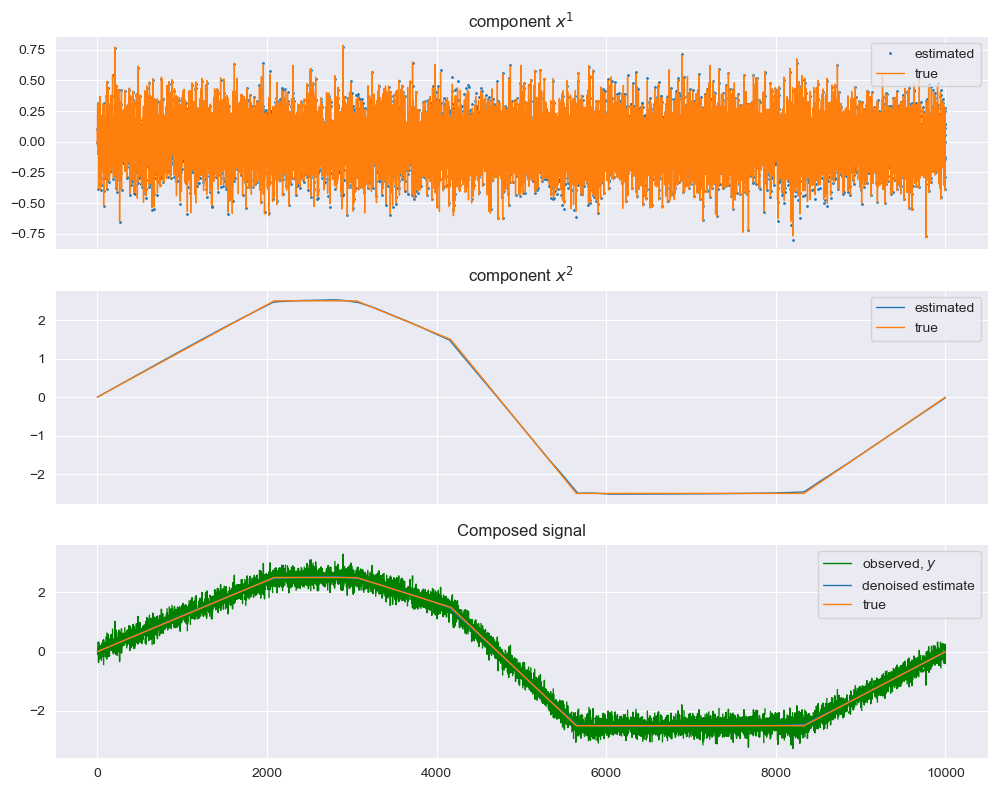

In [12]:
problem.plot_decomposition(X_real=X_real);

## Is the estimated trend outside the range?

In [15]:
print(f"estimated min: {np.min(problem.decomposition[1]):.2f}\nestimated max: {np.max(problem.decomposition[1]):.2f}")

estimated min: -2.52
estimated max: 2.53


## How sparse is the 2nd-diff of the solution?

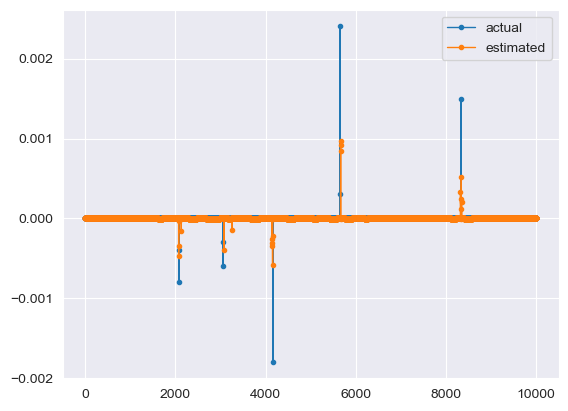

In [21]:
fix, ax = plt.subplots(nrows=1, sharex=True)
ax.plot(np.diff(pwl, n=2), linewidth=1, label='actual', marker='.')
ax.plot(np.diff(problem.decomposition[1], n=2), linewidth=1, label='estimated', marker='.')
ax.legend();

# Constrained $\ell_1$ Problem Formulation

In [22]:
c1 = comp.SumSquare(weight=1/len(y))
c2 = comp.Aggregate([
    comp.SumAbs(diff=2, weight=1),
    comp.Inequality(vmax=2.5, vmin=-2.5)
])

problem = Problem(y, [c1, c2])
problem.decompose(verbose=True)

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      1.48e-02s
(standard algorithm)

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 1.75e+00    1.31e+00     1.97e-01   [0.1 0.1 0.1]  1.49e-03
   25 | 9.05e-01    6.04e-02     5.97e-03   [0.1 0.1 0.1]  2.99e-02
   50 | 1.58e-01    7.05e-01     2.23e+00   [1.e-06 1.e+06 1.e-06]  6.48e-02
   75 | 4.00e-02    1.66e-02     1.27e-01   [1.e-06 1.e+06 1.e-06]  9.34e-02
  100 | 1.95e-01    1.76e-01     4.14e-02   [8.10120345e-01 2.33891078e-01 1.00000000e-06]  1.25e-01
  125 | 1.13e-01    5.13e-03    

# Solve with MOSEK

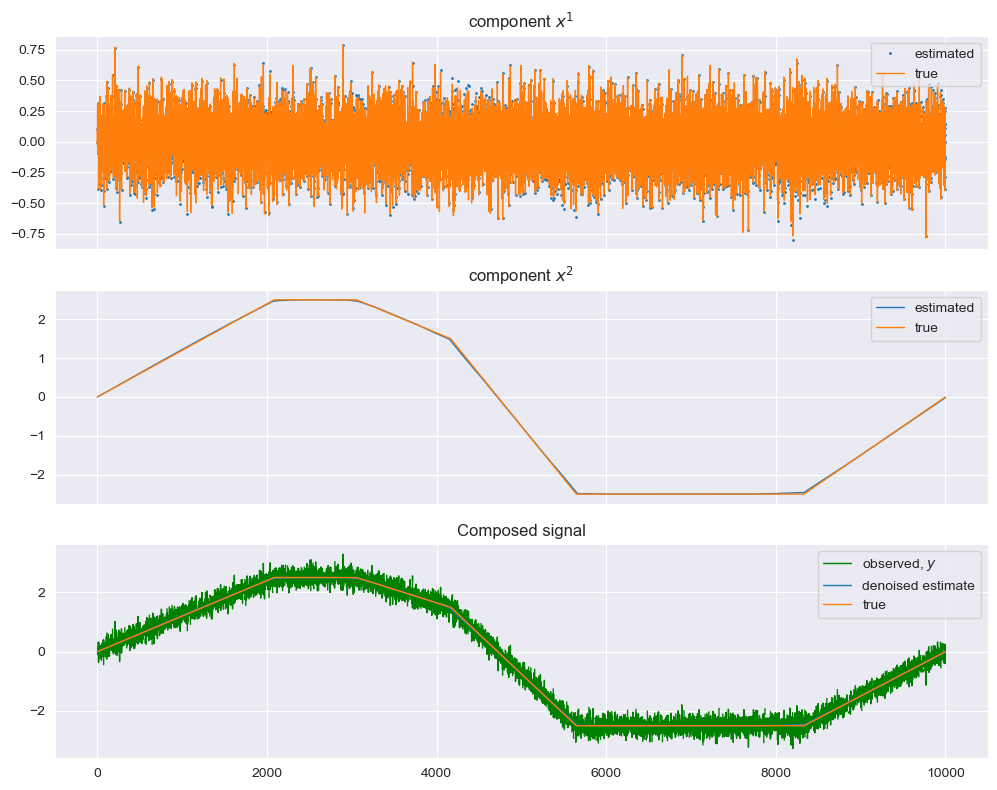

In [23]:
problem.plot_decomposition(X_real=X_real);

## Is the estimated trend outside the range?

In [24]:
print(f"estimated min: {np.min(problem.decomposition[1]):.2f}\nestimated max: {np.max(problem.decomposition[1]):.2f}")

estimated min: -2.50
estimated max: 2.50


## How sparse is the 2nd-diff of the solution?

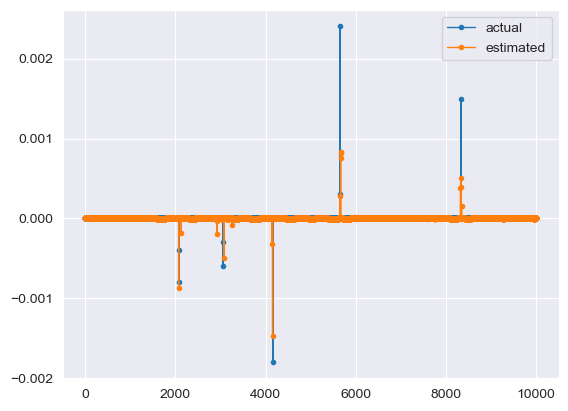

In [25]:
fix, ax = plt.subplots(nrows=1, sharex=True)
ax.plot(np.diff(pwl, n=2), linewidth=1, label='actual', marker='.')
ax.plot(np.diff(problem.decomposition[1], n=2), linewidth=1, label='estimated', marker='.')
ax.legend();